# 04_RandomForest_Diabetes

**Proyecto:** MLY0100 — Clasificación de Riesgo de Diabetes  
**Modelo:** Random Forest Classifier  
**Autor:** Antonio Sepúlveda  
**Fecha:** 2025


## 1. Conexión con Kedro y carga de datos
En este notebook entrenaremos un **Random Forest Classifier** utilizando el dataset limpio del pipeline Kedro.

**Dataset:** `diabetes_cleaned`


In [17]:
import pandas as pd

# Cargar dataset limpio desde ruta
df_diabetes = pd.read_csv("../../mly0100parcial-kedro/data/02_intermediate/diabetes_cleaned.csv")

df_diabetes.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 2. Distribución del Target (Outcome)

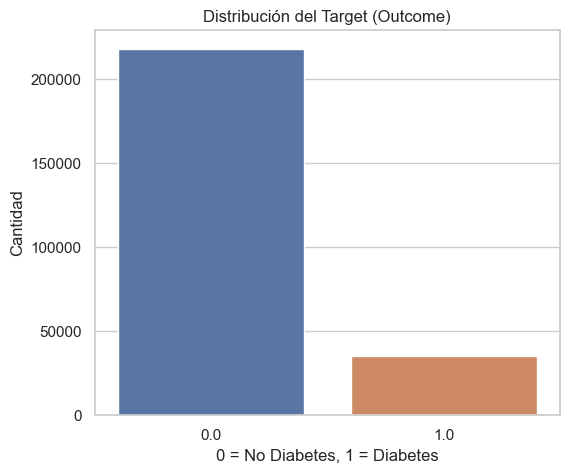


Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(6,5))
sns.countplot(data=df_diabetes, x="Diabetes_binary")
plt.title("Distribución del Target (Outcome)")
plt.xlabel("0 = No Diabetes, 1 = Diabetes")
plt.ylabel("Cantidad")
plt.show()

df_diabetes["Diabetes_binary"].value_counts(normalize=True)


## 3. Importaciones del modelo y métricas

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)

## 4. Selección de variables

In [21]:
# Selección de variables
# X = todas las columnas excepto la variable objetivo
X = df_diabetes.drop("Diabetes_binary", axis=1)

# y = variable objetivo
y = df_diabetes["Diabetes_binary"]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

X.head()


Dimensiones de X: (253680, 21)
Dimensiones de y: (253680,)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 5. Split de entrenamiento y prueba (80/20)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

## 6. Modelo Random Forest — Versión Base

In [23]:
rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
y_proba_base = rf_base.predict_proba(X_test)[:,1]

## 7. Métricas del modelo base

In [24]:
acc = accuracy_score(y_test, y_pred_base)
prec = precision_score(y_test, y_pred_base)
rec = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print(classification_report(y_test, y_pred_base))

Accuracy : 0.8597
Precision: 0.4903
Recall   : 0.1757
F1-score : 0.2587

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.49      0.18      0.26      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.57      0.59     50736
weighted avg       0.82      0.86      0.83     50736



### 7.1 Matriz de confusión

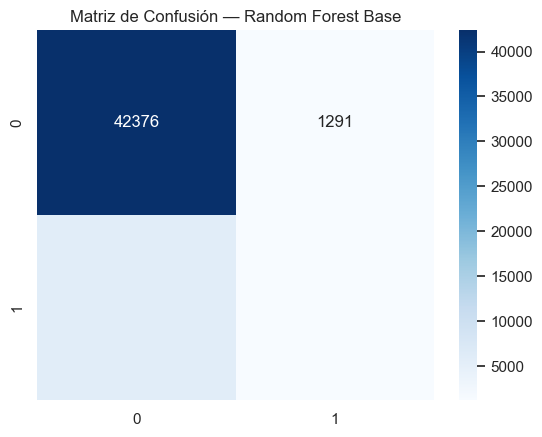


array([[42376,  1291],
       [ 5827,  1242]])

In [25]:
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión — Random Forest Base")
plt.show()

cm

### 7.2 Sensitivity & Specificity

In [26]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.1757
Specificity: 0.9704


## 8. Curvas ROC y Precision-Recall

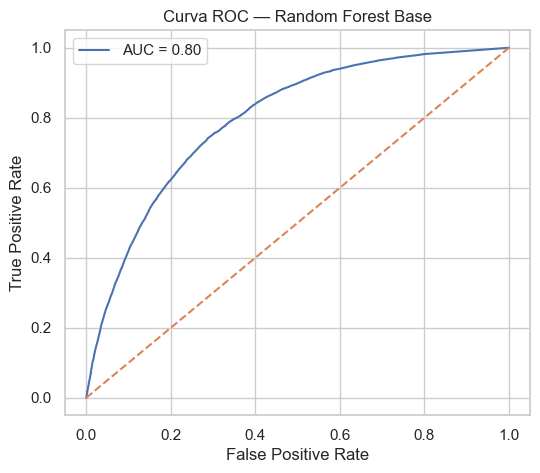

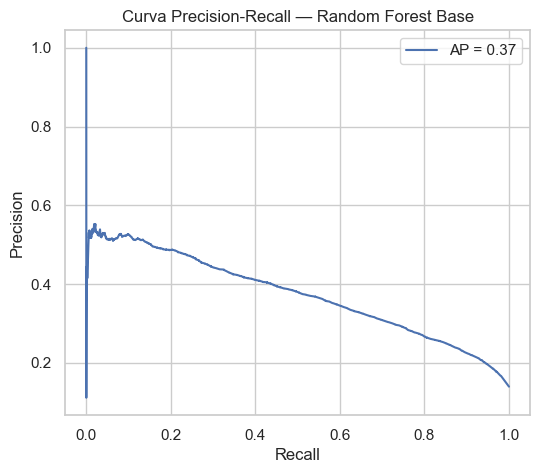

In [27]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_base)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Random Forest Base")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_base)
ap = average_precision_score(y_test, y_proba_base)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall — Random Forest Base")
plt.grid(True)
plt.legend()
plt.show()

## 9. Importancia de características

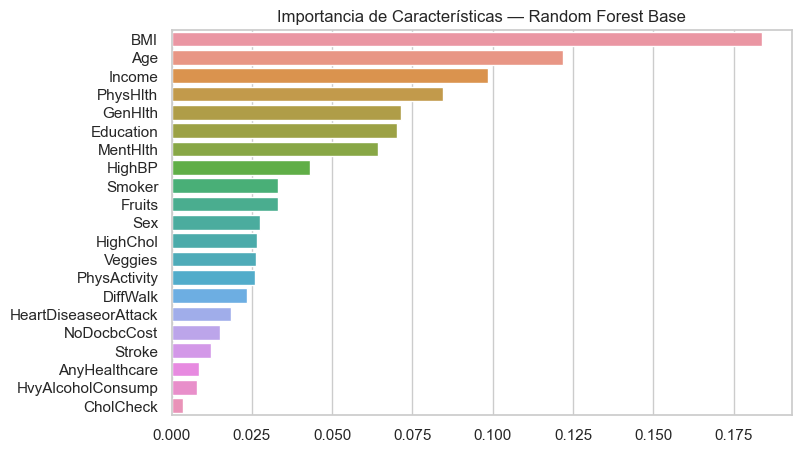


BMI                     0.183869
Age                     0.121970
Income                  0.098667
PhysHlth                0.084372
GenHlth                 0.071503
Education               0.070192
MentHlth                0.064209
HighBP                  0.043104
Smoker                  0.033159
Fruits                  0.033059
Sex                     0.027639
HighChol                0.026580
Veggies                 0.026231
PhysActivity            0.025991
DiffWalk                0.023598
HeartDiseaseorAttack    0.018359
NoDocbcCost             0.015095
Stroke                  0.012416
AnyHealthcare           0.008608
HvyAlcoholConsump       0.007798
CholCheck               0.003581
dtype: float64

In [28]:
importances = pd.Series(rf_base.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Importancia de Características — Random Forest Base")
plt.show()

importances

## 10. Optimización de hiperparámetros — GridSearchCV

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 │   n_jobs=-1                                                                               │
│   16 )                                                                                           │
│   17                                                                                             │
│ ❱ 18 grid_rf.fit(X_train, y_train)                                                               │
│   19                                                                                             │
│   20 print(grid_rf.best_params_)                                                                 │
│   21 print(grid_rf.best_score_)                                                                  │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\base.py:1473 in wrapper              │
│                                                                                                  │
│   1470 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1471 │   │   │   │   )                                                                         │
│   1472 │   │   │   ):                                                                            │
│ ❱ 1473 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1474 │   │                                                                                     │
│   1475 │   │   return wrapper                                                                    │
│   1476                                                                                           │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1019 in   │
│ fit                                                                                              │
│                                                                                                  │
│   1016 │   │   │   │                                                                             │
│   1017 │   │   │   │   return results                                                            │
│   1018 │   │   │                                                                                 │
│ ❱ 1019 │   │   │   self._run_search(evaluate_candidates)                                         │
│   1020 │   │   │                                                                                 │
│   1021 │   │   │   # multimetric is determined here because in the case of a callable            │
│   1022 │   │   │   # self.scoring the return type is only known after calling                    │
│                                                                                                  │
│ c:\Users\goku8\OneDrive\Escritorio\MCHL -                                                        │
│ copiaaaaa\MLY0100-Parcial-1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1573 in   │
│ _run_search                                                                                      │
│                                                                                                  │
│   1570 │                                                                                         │
│   1571 │   def _run_search(self, evaluate_candidates):     

## Evaluacion con GridSearchCV reducido:

In [34]:
# GridSearch reducido y rápido
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [8, 12],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor accuracy CV:", grid_rf.best_score_)


Mejores parámetros: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Mejor accuracy CV: 0.8662931646168402


## 11. Evaluación del mejor modelo

In [36]:
best_rf = grid_rf.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:,1]

acc_b = accuracy_score(y_test, y_pred_best)
prec_b = precision_score(y_test, y_pred_best)
rec_b = recall_score(y_test, y_pred_best)
f1_b = f1_score(y_test, y_pred_best)

print(f"Accuracy  (Best): {acc_b:.4f}")
print(f"Precision (Best): {prec_b:.4f}")
print(f"Recall    (Best): {rec_b:.4f}")
print(f"F1-score  (Best): {f1_b:.4f}\n")

print(classification_report(y_test, y_pred_best))

Accuracy  (Best): 0.8652
Precision (Best): 0.5880
Recall    (Best): 0.1082
F1-score  (Best): 0.1828

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43667
         1.0       0.59      0.11      0.18      7069

    accuracy                           0.87     50736
   macro avg       0.73      0.55      0.55     50736
weighted avg       0.83      0.87      0.82     50736



### 11.1 Matriz de Confusión — Best Model

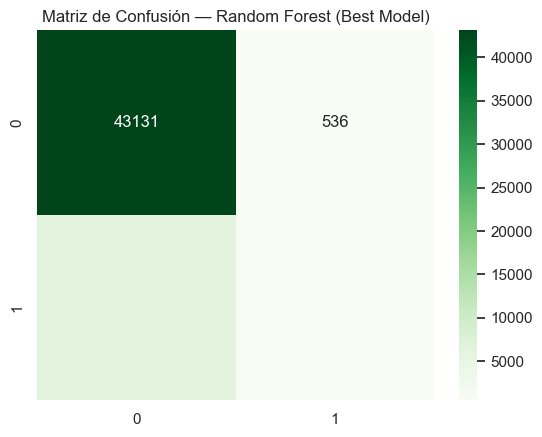


array([[43131,   536],
       [ 6304,   765]])

In [37]:
cm_b = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión — Random Forest (Best Model)")
plt.show()

cm_b

### 11.2 Sensitivity & Specificity — Best Model

In [38]:
tn, fp, fn, tp = cm_b.ravel()
sensitivity_b = tp / (tp + fn)
specificity_b = tn / (tn + fp)

print(f"Sensitivity (Best): {sensitivity_b:.4f}")
print(f"Specificity (Best): {specificity_b:.4f}")

Sensitivity (Best): 0.1082
Specificity (Best): 0.9877


### 11.3 Curvas ROC y PR — Best Model

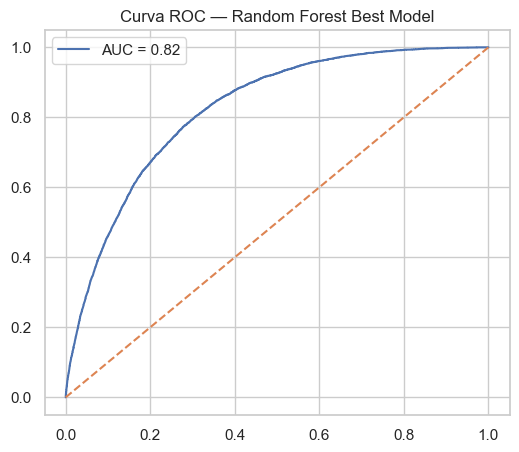

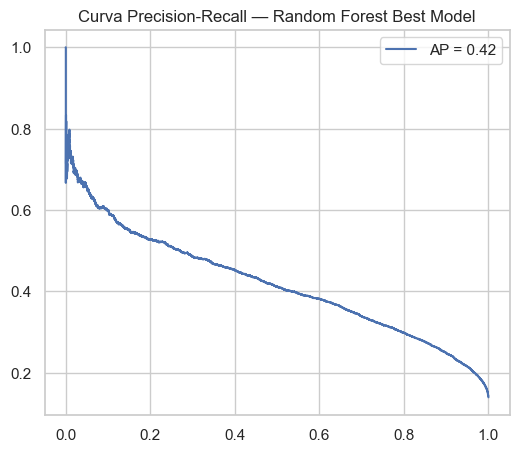

In [39]:
# ROC
fpr_b, tpr_b, _ = roc_curve(y_test, y_proba_best)
auc_b = auc(fpr_b, tpr_b)

plt.figure(figsize=(6,5))
plt.plot(fpr_b, tpr_b, label=f"AUC = {auc_b:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("Curva ROC — Random Forest Best Model")
plt.legend()
plt.grid(True)
plt.show()

# PR
precision_b, recall_b, _ = precision_recall_curve(y_test, y_proba_best)
ap_b = average_precision_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(recall_b, precision_b, label=f"AP = {ap_b:.2f}")
plt.title("Curva Precision-Recall — Random Forest Best Model")
plt.legend()
plt.grid(True)
plt.show()